## 

## Fitting RL model Hyun data.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import scipy
import pandas as pd

from matplotlib.lines import Line2D

In [2]:
seed = sum(map(ord, "RL_PyMC"))
rng = np.random.default_rng(seed)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

In [19]:
# load data
data = pd.read_csv("./data/Sample-JH_OFC_201210-5HT-1_FR-3_LtoR_11.csv")
data_sero = pd.read_csv("./data/Sample-JH_OFC_201215-5HT-1_FR-3_LtoR_12.csv")

In [20]:
data.head()

,timestamp (s),choice,answer,reward number,first_reversal,Session,Unnamed: 6
0,181.185143,L,L,NaN,NaN,JH_OFC_201210-5HT-1,NaN
1,182.585675,L,L,NaN,NaN,FR-3_LtoR_11,NaN
2,183.486143,L,L,1.0,0.0,NaN,NaN
3,191.509352,L,L,NaN,0.0,before 5-HT control,NaN
4,192.396955,L,L,NaN,0.0,NaN,NaN


In [21]:
data_sero.head()

,timestamp (s),choice,answer,reward number,first_reversal,Session
0,226.124397,R,L,NaN,0,JH_OFC_201215-5HT-1
1,228.012001,L,L,NaN,0,FR-3_LtoR_12
2,230.149204,L,L,NaN,0,NaN
3,231.802807,L,L,1.0,0,after 5-HT control
4,237.434417,L,L,NaN,0,NaN


In [22]:
data["choice"] = data["choice"].replace("L", 0)
data["choice"] = data["choice"].replace("R", 1)
data_sero["choice"] = data_sero["choice"].replace("L", 0)
data_sero["choice"] = data_sero["choice"].replace("R", 1)

In [6]:
def replace_values(val):
    if np.isnan(val):
        return 0
    elif isinstance(val, float):
        return 1
    else:
        return val

In [23]:
data["reward number"] = data["reward number"].apply(replace_values)
data_sero["reward number"] = data_sero["reward number"].apply(replace_values)

In [25]:
data.head()

,timestamp (s),choice,answer,reward number,first_reversal,Session,Unnamed: 6
0,181.185143,0,L,0,NaN,JH_OFC_201210-5HT-1,NaN
1,182.585675,0,L,0,NaN,FR-3_LtoR_11,NaN
2,183.486143,0,L,1,0.0,NaN,NaN
3,191.509352,0,L,0,0.0,before 5-HT control,NaN
4,192.396955,0,L,0,0.0,NaN,NaN


In [26]:
data_sero.head()

,timestamp (s),choice,answer,reward number,first_reversal,Session
0,226.124397,1,L,0,0,JH_OFC_201215-5HT-1
1,228.012001,0,L,0,0,FR-3_LtoR_12
2,230.149204,0,L,0,0,NaN
3,231.802807,0,L,1,0,after 5-HT control
4,237.434417,0,L,0,0,NaN


In [9]:
choice = data["choice"].values
reward = data["reward number"].values

In [10]:
choice

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0])

In [11]:
reward

array([0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [27]:
len(reward)

181

In [28]:
choice_sero = data_sero["choice"].values
reward_sero = data_sero["reward number"].values

In [29]:
choice_sero

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [30]:
reward_sero

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1])

In [31]:
len(choice_sero)

92

In [13]:
def update_Q(action, reward, Qs, alpha):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by pytensor.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the pytensor.scan fn argument:
        fn=lamba action, reward, Qs, alpha: pt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """

    Qs = pt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    return Qs

In [14]:
def right_action_probs(alpha, beta, actions, rewards):
    rewards = pt.as_tensor_variable(rewards, dtype="int32")
    actions = pt.as_tensor_variable(actions, dtype="int32")

    # Compute the Qs values
    Qs = 0.5 * pt.ones((2,), dtype="float64")
    Qs, updates = pytensor.scan(
        fn=update_Q,
        sequences=[actions, rewards],
        outputs_info=[Qs],
        non_sequences=[alpha],
    )

    # Apply the sotfmax transformation
    Qs = Qs[:-1] * beta
    logp_actions = Qs - pt.logsumexp(Qs, axis=1, keepdims=True)

    # Return the probabilities for the right action, in the original scale
    return pt.exp(logp_actions[:, 1])

In [15]:
with pm.Model() as m_alt:
    alpha = pm.Beta(name="alpha", alpha=1, beta=1)
    beta = pm.HalfNormal(name="beta", sigma=10)

    action_probs = right_action_probs(alpha, beta, choice, reward)
    like = pm.Bernoulli(name="like", p=action_probs, observed=choice[1:])

    tr_alt = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

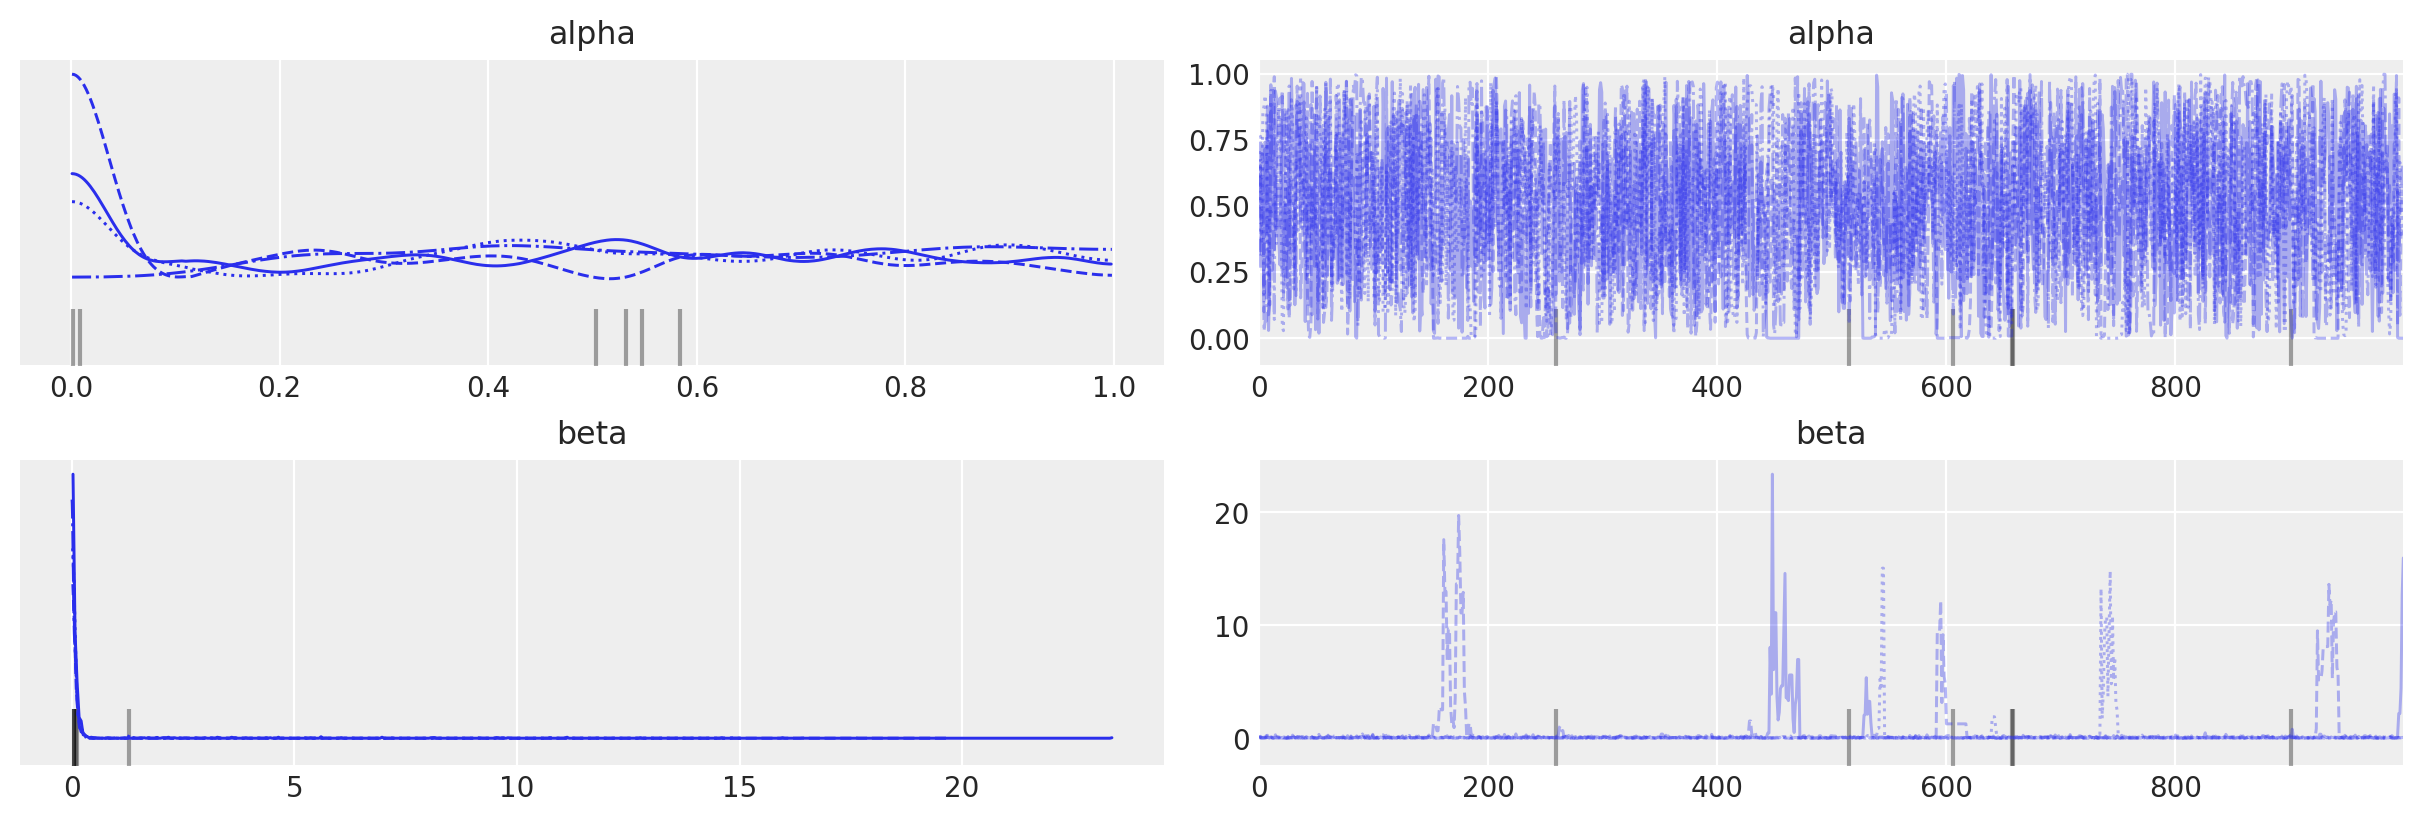

In [16]:
az.plot_trace(data=tr_alt)

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>], dtype=object)

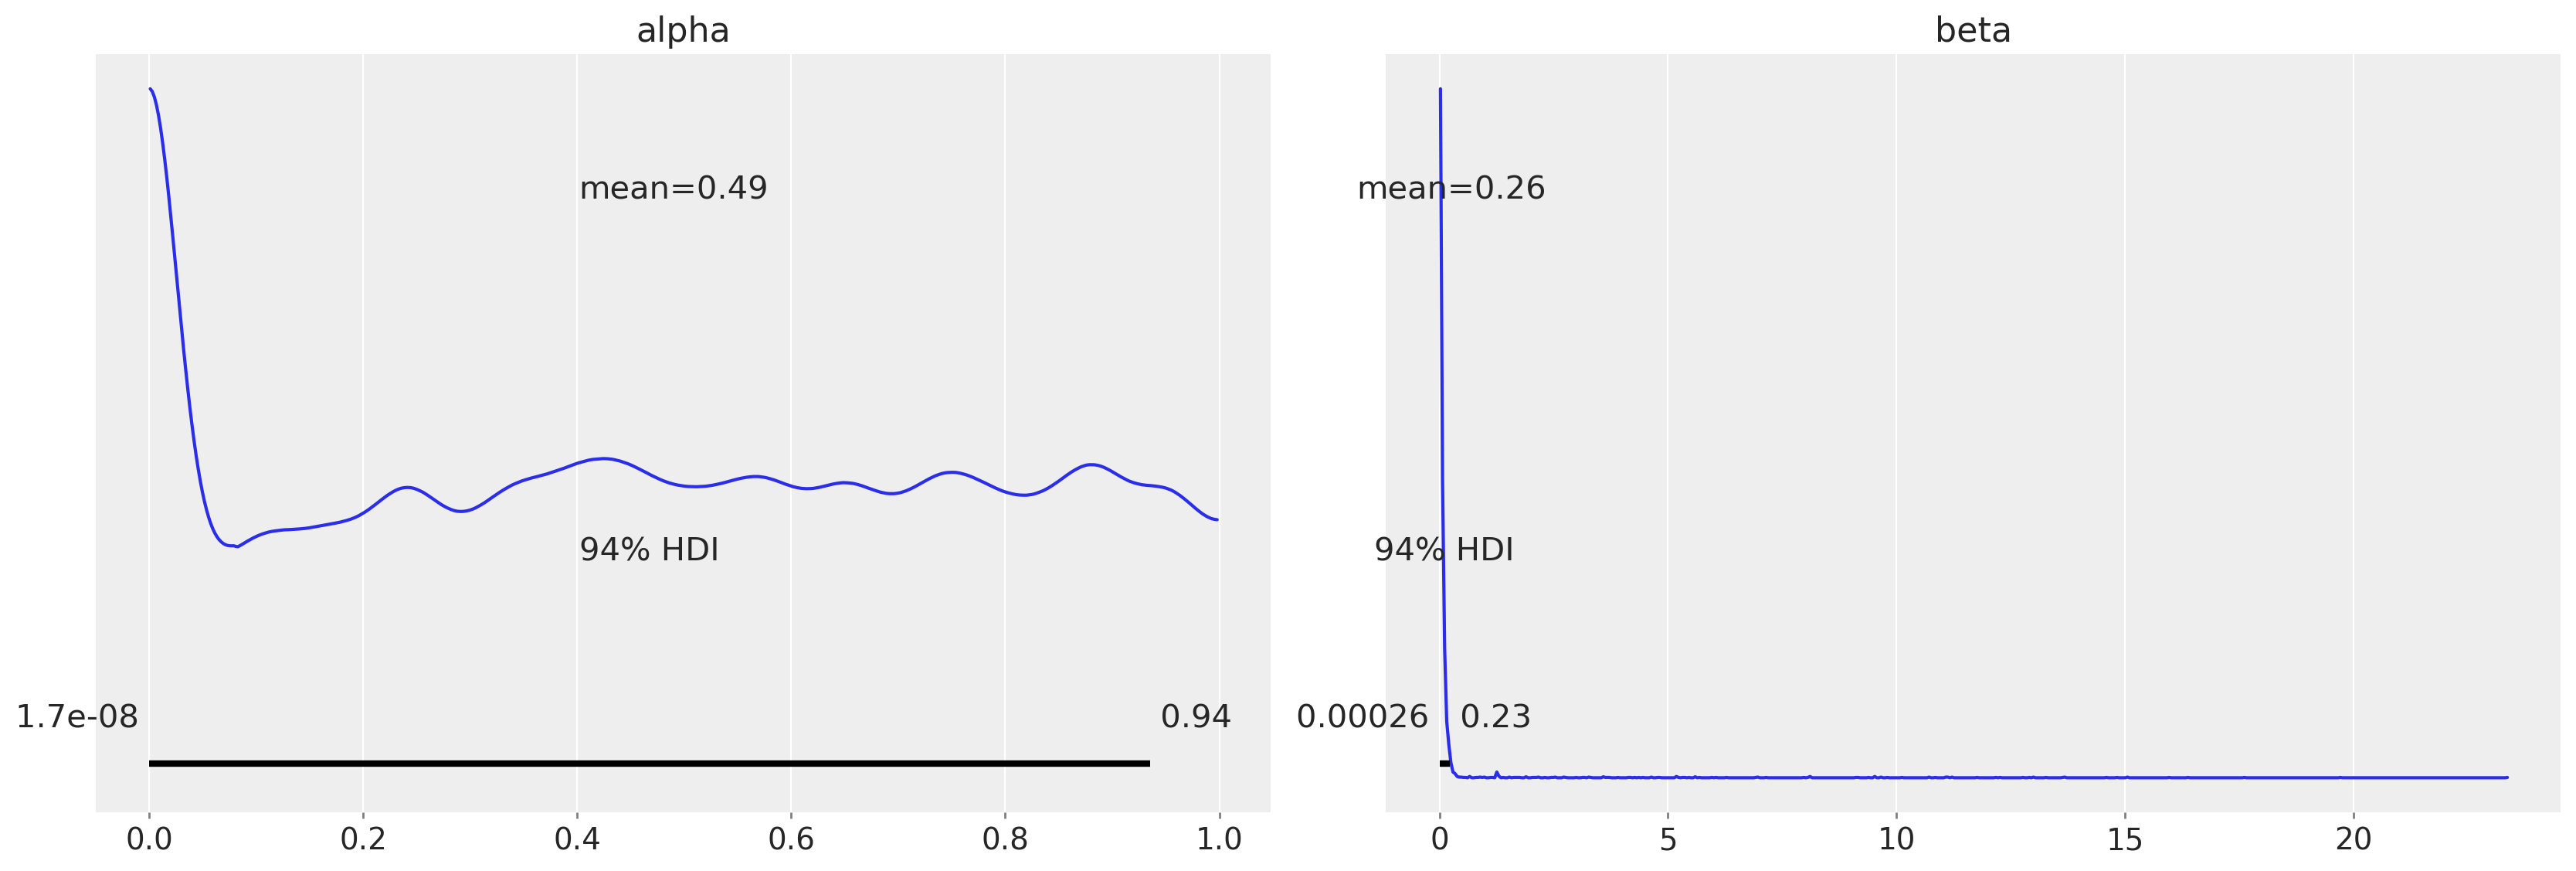

In [17]:
az.plot_posterior(data=tr_alt)

In [32]:
with pm.Model() as m_alt:
    alpha = pm.Beta(name="alpha", alpha=1, beta=1)
    beta = pm.HalfNormal(name="beta", sigma=10)

    action_probs = right_action_probs(alpha, beta, choice_sero, reward_sero)
    like = pm.Bernoulli(name="like", p=action_probs, observed=choice_sero[1:])

    tr_alt = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

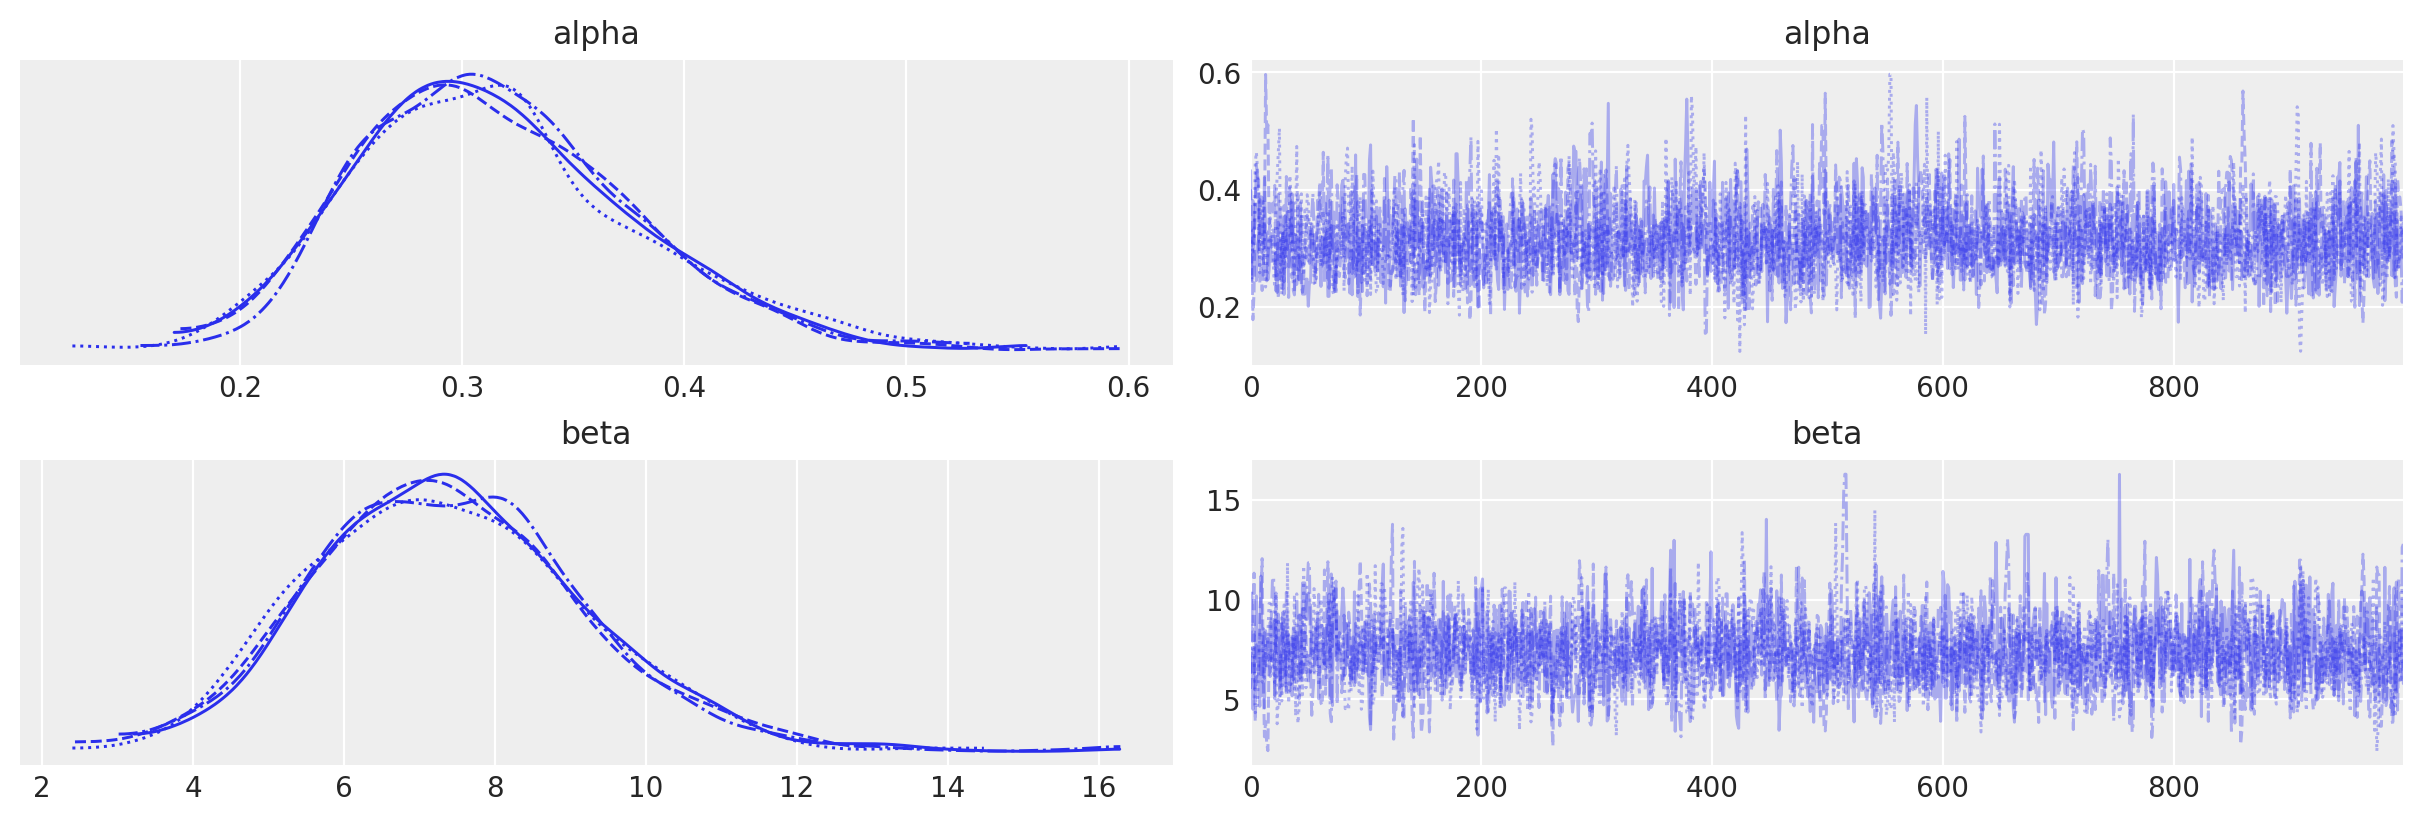

In [33]:
az.plot_trace(data=tr_alt)

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>], dtype=object)

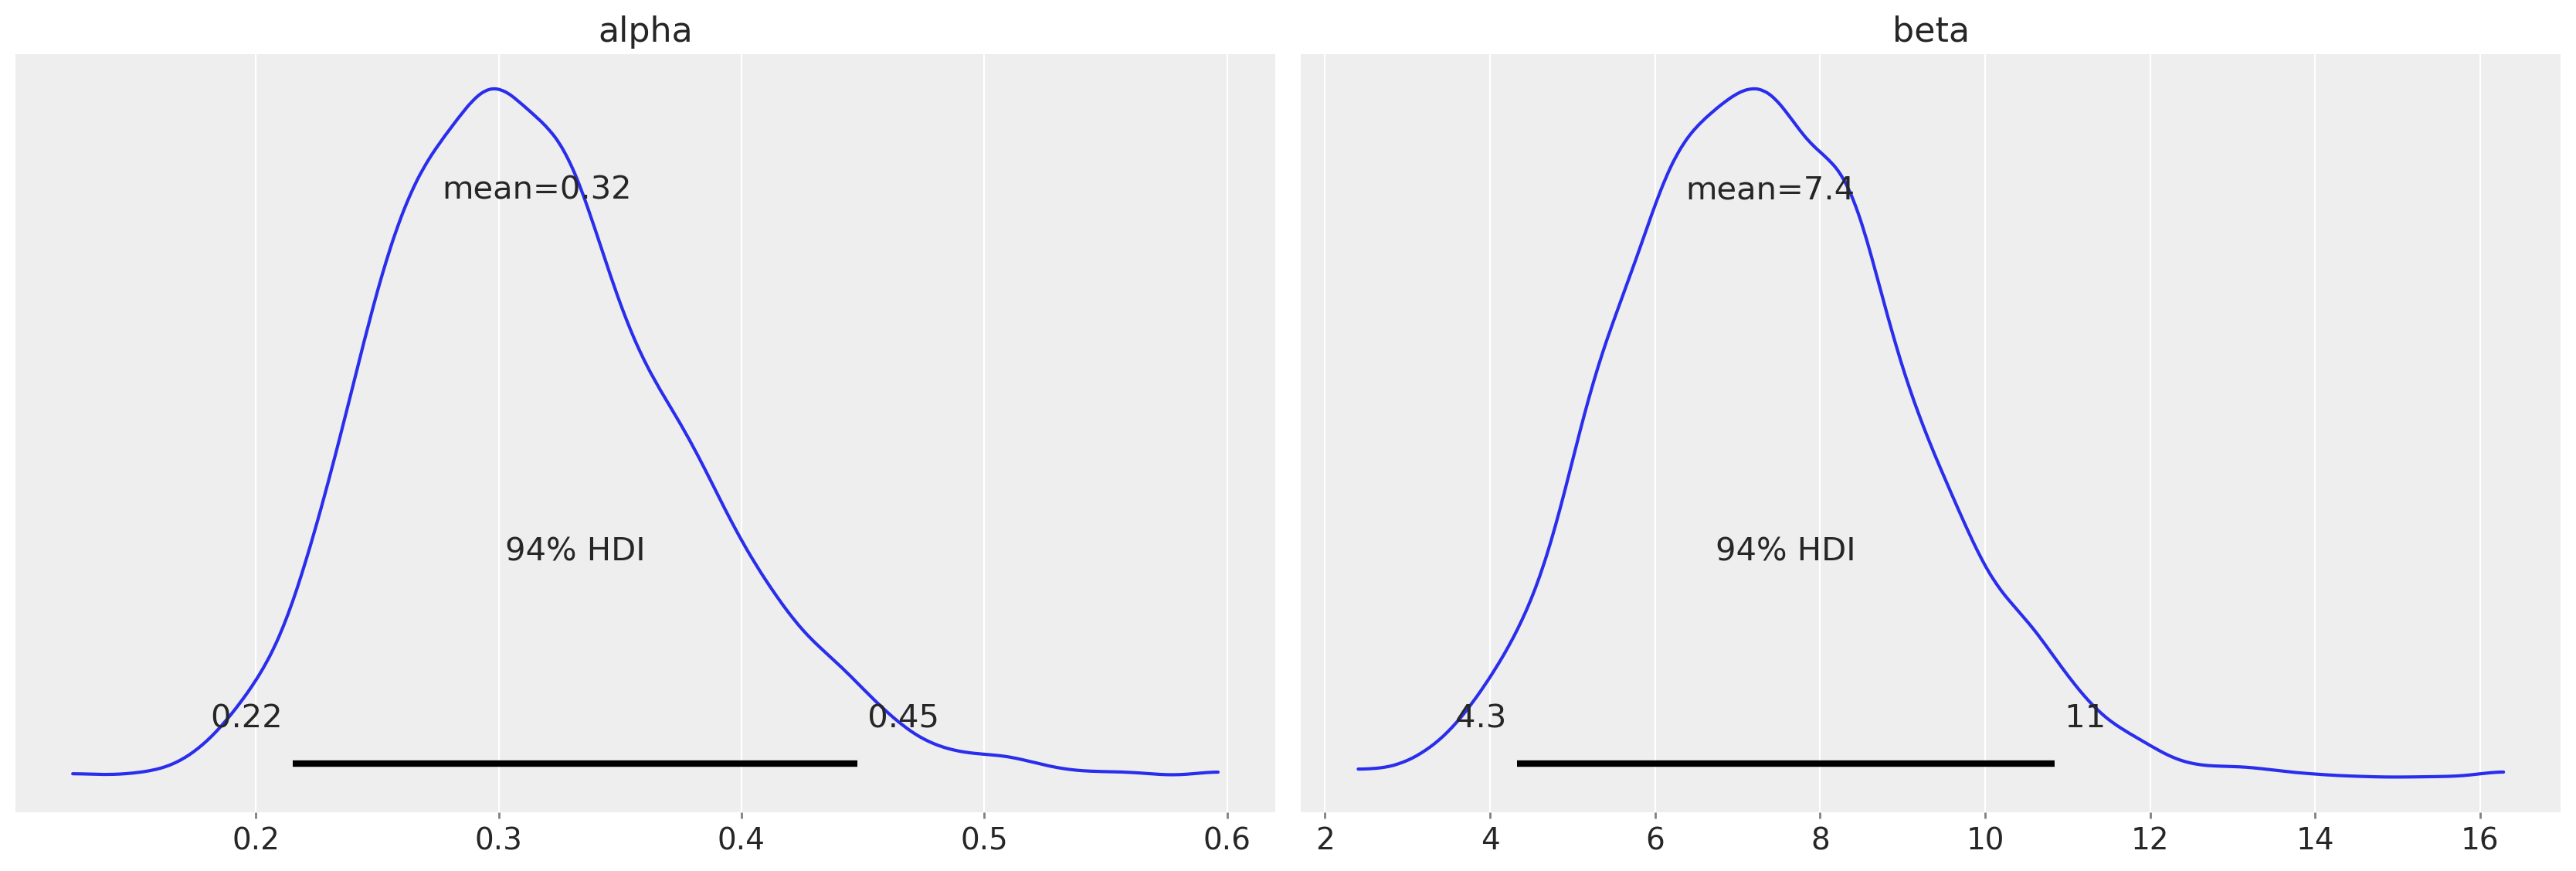

In [34]:
az.plot_posterior(data=tr_alt)